# Emittance minimization using Xopt with BAXGenerator running algorithm ScipyMinimizeEmittance
In this notebook we demonstrate the use of Xopt to perform Bayesian Algorithm Execution (BAX) as a means of minimizing the emittance described by a simple optical beam size model. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import sys
# sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.beam_dynamics import compute_emit_bmag
from emitopt.sampling import draw_product_kernel_post_paths
from emitopt.algorithms import ScipyMinimizeEmittanceXY

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
# if torch.cuda.is_available():
if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    use_cuda = True
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

# Notebook settings

In [3]:
ndim = 4 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
thick_quad = False
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 5 #number of random initial observations for GP model
n_samples = 10 #number of posterior samples for BAX
n_iter = 100 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 2

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [4]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

q_len = CONFIG['beamline_info']['Lquad']
rmat_x = torch.tensor(CONFIG['beamline_info']['rMatx']).reshape(2,2)
rmat_y = torch.tensor(CONFIG['beamline_info']['rMaty']).reshape(2,2)

In [5]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])


# define variables functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

scale = 1.e7
def measure_beamsize(input_dict):
    x_tuning = torch.tensor([])
    for key in input_dict.keys():
        if key is not meas_param:
            x_tuning = torch.cat((x_tuning, torch.tensor([input_dict[key]])))
    rms_beamsizes0 = np.array(sim.beam_size_meas(input_dict[meas_param]))
    detuning_scale = 1. + x_tuning.abs().sum().cpu()
    xrms, yrms = detuning_scale * rms_beamsizes0
    return {'xrms_sq': float(xrms)**2.*scale,
            'yrms_sq': float(yrms)**2.*scale} # mean-square beam sizes in mm squared

from emitopt.beam_dynamics import get_quad_scale_factor
scale_factor = get_quad_scale_factor(E=.08, q_len=q_len)
# scale_factor = 1.
q = torch.linspace(-3,3,11)
bss = torch.tensor([np.array(sim.beam_size_meas(v))**2*scale for v in q.numpy()]).T
k = scale_factor*q
ks = torch.stack((k,-k))
rmats = torch.stack((rmat_x, rmat_y))
emit, bmag, sig, is_valid = compute_emit_bmag(ks, bss, q_len, rmats, get_bmag=False, thick=thick_quad)
gt_emit_min = (emit[0]*emit[1]).sqrt()
def ground_truth_geometric_mean_emittance(emit_min, x_tuning):
    detuning_scale = 1. + x_tuning.abs().sum(dim=1)
    emit = emit_min * detuning_scale**2
    return emit

print('Ground truth minimum emit:', gt_emit_min)

Ground truth minimum emit: tensor(0.6091)


# Construct vocs

In [6]:
variables = {var_name: [-1.5,0.5] for var_name in var_names}
variables[meas_param] = [-3,3] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq']
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1', 'x2', 'x3']
meas_param = 'x1'
domain =
 [[-1.5  0.5]
 [-3.   3. ]
 [-1.5  0.5]
 [-1.5  0.5]]


# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [7]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator
from emitopt.algorithms import ScipyMinimizeEmittanceXY

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [8]:
from xopt.numerical_optimizer import LBFGSOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_raw_samples=20,
                                    n_restarts=10,
                                    max_iter=50)

# Construct generator, evaluator, Xopt objects

In [9]:
#Prepare Algorithm
algo_kwargs = {
        'x_key': 'xrms_sq',
        'y_key': 'yrms_sq',
        'scale_factor': scale_factor,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 11,
#         'scipy_options': None,
        'thick_quad': thick_quad,
}
algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

#construct evaluator
evaluator = Evaluator(function=measure_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

Verifying model name='standard' use_low_noise_prior=True covar_modules={'xrms_sq': ScaleKernel(
  (base_kernel): ProductKernel(
    (kernels): ModuleList(
      (0): MaternKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (1): PolynomialKernel(
        (raw_offset_constraint): Positive()
      )
    )
  )
  (raw_outputscale_constraint): Positive()
), 'yrms_sq': ScaleKernel(
  (base_kernel): ProductKernel(
    (kernels): ModuleList(
      (0): MaternKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (1): PolynomialKernel(
        (raw_offset_constraint): Positive()
      )
    )
  )
  (raw_outputscale_constraint): Positive()
)} mean_modules={} trainable_mean_keys=[]


# Optimize

In [10]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(n_obs_init)

,x0,x1,x2,x3,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-0.371990,1.017991,-0.742268,-1.070670,1.225419,76.210492,0.000543,False
1,0.448148,1.772108,-0.558284,-1.207951,0.770803,128.120400,0.000222,False
2,-0.599325,-0.715626,0.230840,-0.488474,11.896296,5.313815,0.000193,False
3,-0.370645,1.202072,-0.527156,-1.193123,0.598224,82.049292,0.000194,False
4,-0.340736,1.399036,0.131120,0.340709,0.112033,32.270022,0.000197,False


In [11]:
# torch.tensor(optimizer.data[vocs.variable_names].iloc[-2].to_numpy().reshape(1,-1))

In [12]:
results = {}

In [13]:
# plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
# plt.xlabel('Predicted Optimal Emittance')
# plt.ylabel('Probability Density')
# plt.show()
# print('sample validity rate:', svr)

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP models
    model = optimizer.generator.train_model()
    bax_model_ids = [optimizer.generator.vocs.output_names.index(name)
                            for name in optimizer.generator.algorithm.model_names_ordered]
    bax_model = model.subset_output(bax_model_ids)
    beam_size_model_x = bax_model.models[0]
    beam_size_model_y = bax_model.models[1]
    
    #extract and store algorithm results for this iteration
    results[i] = optimizer.generator.algorithm_results
#     beam_size_models[i] = beam_size_model
    
    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    algo = optimizer.generator.algorithm
#     X_tuned, emits_at_target_valid, svr = algo.mean_output(beam_size_model,
#                                                          torch.tensor(vocs.bounds),
#                                                          num_restarts=10)
    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

#     if i % 5 == 0:
#         plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
#         plt.xlabel('Predicted Optimal Emittance')
#         plt.ylabel('Probability Density')
#         plt.show()
#         print('sample validity rate:', svr)

Iteration: 1 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 2 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior sample jacobians 2 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance took 1 steps in get_sample_optimal_tuning_configs().
This iteration took: 5.742429256439209 seconds.

Iteration: 2 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 2 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior sample jacobians 2 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance took 1 steps in get_sample_optimal_tuning_configs().
This iteration took: 3.818648099899292 seconds.

Iteration: 3 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 192 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior sample jacobians 192 times in get_sample_optimal_tu

This iteration took: 5.125470161437988 seconds.

Iteration: 22 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 57 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior sample jacobians 57 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance took 28 steps in get_sample_optimal_tuning_configs().
This iteration took: 3.156017780303955 seconds.

Iteration: 23 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 98 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior sample jacobians 98 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance took 40 steps in get_sample_optimal_tuning_configs().
This iteration took: 3.56345534324646 seconds.

Iteration: 24 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 218 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) post

This iteration took: 3.0773026943206787 seconds.

Iteration: 44 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 252 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior sample jacobians 252 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance took 88 steps in get_sample_optimal_tuning_configs().
This iteration took: 7.1274573802948 seconds.

Iteration: 45 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 141 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior sample jacobians 141 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance took 45 steps in get_sample_optimal_tuning_configs().
This iteration took: 5.227517366409302 seconds.

Iteration: 46 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 177 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) 

This iteration took: 4.321325063705444 seconds.

Iteration: 66 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 22 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior sample jacobians 22 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance took 10 steps in get_sample_optimal_tuning_configs().
This iteration took: 3.303509473800659 seconds.

Iteration: 67 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 84 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior sample jacobians 84 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance took 25 steps in get_sample_optimal_tuning_configs().
This iteration took: 4.564237356185913 seconds.

Iteration: 68 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 47 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) post

This iteration took: 3.981630325317383 seconds.

Iteration: 88 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 32 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior sample jacobians 32 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance took 7 steps in get_sample_optimal_tuning_configs().
This iteration took: 3.9781007766723633 seconds.

Iteration: 89 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 25 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior sample jacobians 25 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance took 7 steps in get_sample_optimal_tuning_configs().
This iteration took: 3.701110363006592 seconds.

Iteration: 90 / 100
ScipyMinimizeEmittance evaluated 10 (pathwise) posterior samples 19 times in get_sample_optimal_tuning_configs().
ScipyMinimizeEmittance evaluated 10 (pathwise) poste

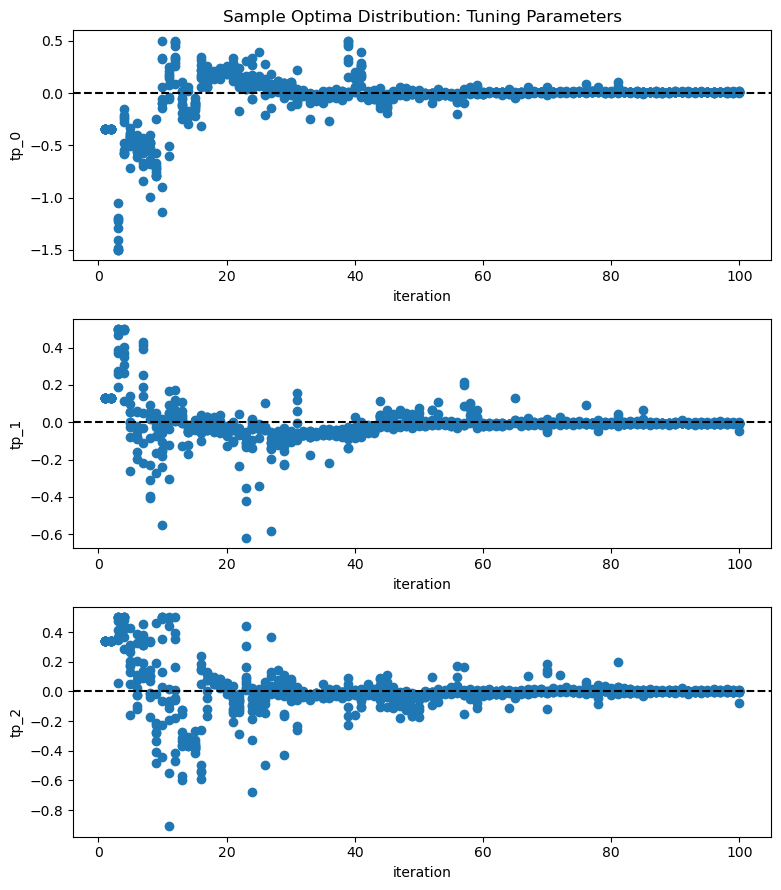

In [24]:
from emitopt.plot_utils import plot_sample_optima_convergence_inputs
fig, axs = plot_sample_optima_convergence_inputs(results, show_valid_only=False)
for ax in axs:
    ax.axhline(0, ls='--', c='k')

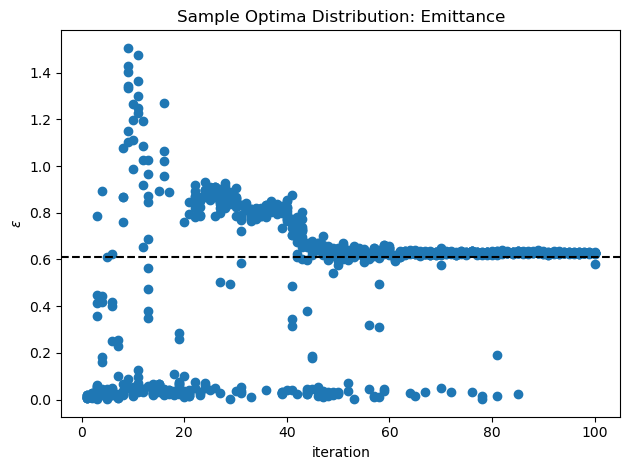

In [25]:
from emitopt.plot_utils import plot_sample_optima_convergence_emits
fig, ax = plot_sample_optima_convergence_emits(results)
ax.axhline(gt_emit_min, ls='--', c='k', label='ground truth')

In [ ]:
from emitopt.plot_utils import plot_pathwise_emittance_vs_tuning
plot_pathwise_emittance_vs_tuning(optimizer, torch.tensor([[0.]]))

# Minimize sample emittance functions produced by current GP beam size model and inspect results

In [19]:
#select sample result

sid = 8 #sample index to examine

# X_tuned = X_sample_opt[sid].reshape(1,-1)
X_tuned = optimizer.generator.algorithm_results['x_tuning_best']
# X_tuned = torch.zeros(1,ndim-1)
print('X_tuned =', X_tuned)
print('mean:', X_tuned.mean(dim=0))

X_tuned = tensor([[[ 1.1919e-02, -3.0307e-03, -2.6309e-03]],

        [[ 1.1956e-02, -2.9808e-03, -5.3588e-03]],

        [[ 1.2773e-02,  2.5101e-03, -5.2219e-03]],

        [[ 1.3120e-02, -5.0941e-03, -1.0266e-02]],

        [[ 8.1018e-03, -9.9156e-03,  6.2272e-03]],

        [[ 4.6821e-03, -5.2007e-03,  1.6857e-03]],

        [[ 1.2967e-02, -3.2240e-03, -9.4384e-05]],

        [[ 7.3265e-03, -4.2976e-03, -1.6553e-03]],

        [[ 1.0602e-02, -4.4065e-03,  3.6168e-04]],

        [[ 4.1098e-03,  4.4800e-04,  1.3087e-02]]])
mean: tensor([[ 0.0098, -0.0035, -0.0004]])


# Sample geometric mean of emittance x&y

X_tuned = tensor([[ 0.0073, -0.0043, -0.0017]])
torch.Size([100])
torch.Size([100, 3])


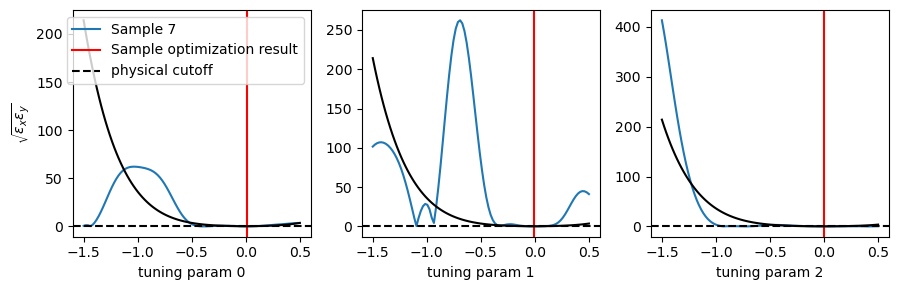

In [20]:
from emitopt.plot_utils import plot_pathwise_sample_emittance_minimization_results
sid = 7
X_tuned = optimizer.generator.algorithm_results['x_tuning_best'][sid:sid+1, 0, :]

fig, axs = plot_pathwise_emittance_vs_tuning(optimizer, x_origin=X_tuned, sample_ids=[sid])#, ground_truth_emittance_fn=ground_truth_geometric_mean_emittance)
X_tuning_scan = X_tuned.repeat(100,1)
ls = torch.linspace(*optimizer.vocs.bounds.T[0],100)
# ls = torch.linspace(-1,1,100)
X_tuning_scan[:,i] = ls
gt_emit_xy = ground_truth_geometric_mean_emittance(emit_min=gt_emit_min, x_tuning=X_tuning_scan)

for ax in axs:
    ax.plot(ls, gt_emit_xy**4, c='k', label='ground truth')

In [ ]:
from emitopt.plot_utils import plot_virtual_emittance_vs_tuning
fig, axs = plot_virtual_emittance_vs_tuning(optimizer, torch.tensor([[0.]]))

In [ ]:
from emitopt.plot_utils import plot_virtual_measurement_scan
plot_virtual_measurement_scan(optimizer, torch.tensor([[0.]]))

In [ ]:
from emitopt.utils import plot_model_cross_section
scan_dict = {'x0':[-3.0, 1.0], 'x1': [-40.0, 40.0], 'x2': 1., 'x3': 0.}
plot_model_cross_section(beam_size_model, vocs, scan_dict, nx=50, ny=15)

In [ ]:
from emitopt.plot_utils import plot_acq_func_opt_results
plot_acq_func_opt_results(optimizer)